In [249]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler

# Loading the Data

In [250]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'NASDAQ'
symbol = '^IXIC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Quick overview of dataset
train_dfs = df.copy()
train_dfs

High          Low         Open        Close      Volume  \
Date                                                                         
2010-01-04  2311.149902  2294.409912  2294.409912  2308.419922  1931380000   
2010-01-05  2313.729980  2295.620117  2307.270020  2308.709961  2367860000   
2010-01-06  2314.070068  2295.679932  2307.709961  2301.090088  2253340000   
2010-01-07  2301.300049  2285.219971  2298.090088  2300.050049  2270050000   
2010-01-08  2317.600098  2290.610107  2292.239990  2317.169922  2145390000   
...                 ...          ...          ...          ...         ...   
2020-05-22  9328.280273  9239.410156  9278.549805  9324.589844  3641830000   
2020-05-26  9501.209961  9333.160156  9501.209961  9340.219727  4432310000   
2020-05-27  9414.620117  9144.280273  9346.120117  9412.360352  4462450000   
2020-05-28  9523.639648  9345.280273  9392.990234  9368.990234  4064220000   
2020-05-29  9505.549805  9324.730469  9382.349609  9489.870117  4710060000   

              Adj Close  
Date                     
2010-01-04  2308.419922  
2010-01-05  2308.709961  
2010-01-06  2301.090088  
2010-01-07  2300.050049  
2010-01-08  2317.169922  
...                 ...  
2020-05-22  9324.589844  
2020-05-26  9340.219727  
2020-05-27  9412.360352  
2020-05-28  9368.990234  
2020-05-29  9489.870117  

[2619 rows x 6 columns]

# Exploring the data

High


<Figure size 432x288 with 0 Axes>

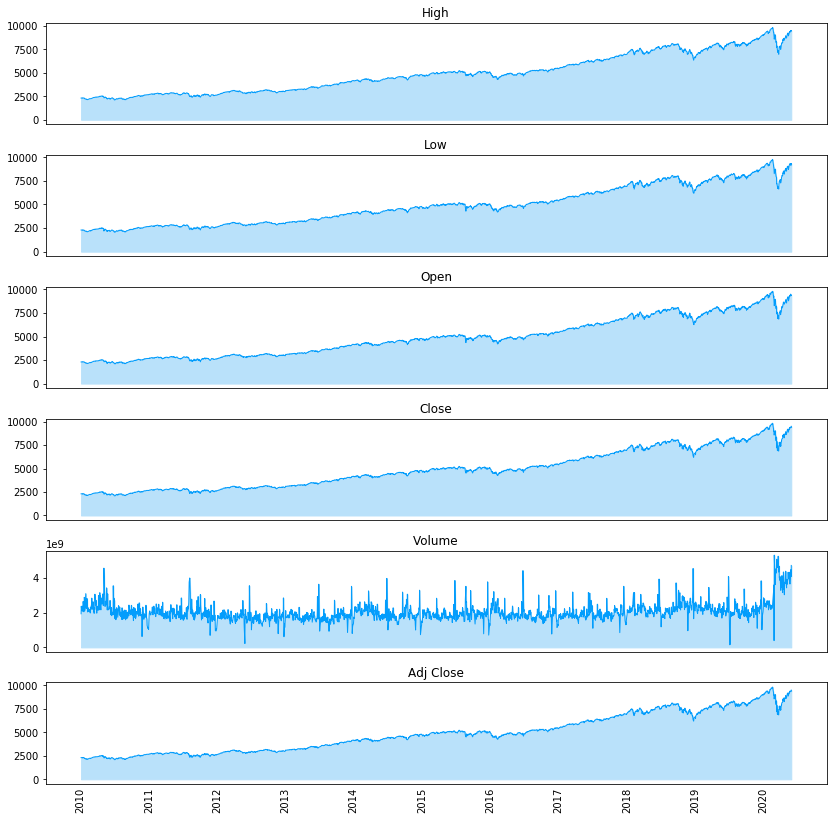

In [251]:
# Plot each column
register_matplotlib_converters()
years = mdates.YearLocator() 
plt.figure()
ncols = train_dfs.shape[1]
fig, ax = plt.subplots(nrows=ncols, ncols=1, sharex=True, figsize=(14, 14))

fig.subplots_adjust(hspace=0.3, wspace=0.5)
x = train_dfs.index
columns = train_dfs.columns
print(columns[0])
for i in range(ncols):
        ax[i].xaxis.set_major_locator(years)
        y = train_dfs[columns[i]]
        #print(y)
        ax[i].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i].set_title(columns[i])
        ax[i].tick_params(axis="x", rotation=90, labelsize=10, length=0)
        ax[i].fill_between(x, 0, y, color='#b9e1fa')        

# Preprocessing and Feature Engineering

In [252]:
# Indexing Batches
train_df = train_dfs.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

High          Low         Open        Close      Volume  \
0  2311.149902  2294.409912  2294.409912  2308.419922  1931380000   
1  2313.729980  2295.620117  2307.270020  2308.709961  2367860000   
2  2314.070068  2295.679932  2307.709961  2301.090088  2253340000   
3  2301.300049  2285.219971  2298.090088  2300.050049  2270050000   
4  2317.600098  2290.610107  2292.239990  2317.169922  2145390000   

     Adj Close Month  Year  
0  2308.419922    01  2010  
1  2308.709961    01  2010  
2  2301.090088    01  2010  
3  2300.050049    01  2010  
4  2317.169922    01  2010

In [310]:
# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 
            #'Year',
            #'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close'] 

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume', 'Month']


High          Low         Open        Close      Volume Month  \
2614  9328.280273  9239.410156  9278.549805  9324.589844  3641830000    05   
2615  9501.209961  9333.160156  9501.209961  9340.219727  4432310000    05   
2616  9414.620117  9144.280273  9346.120117  9412.360352  4462450000    05   
2617  9523.639648  9345.280273  9392.990234  9368.990234  4064220000    05   
2618  9505.549805  9324.730469  9382.349609  9489.870117  4710060000    05   

       Prediction  
2614  9324.589844  
2615  9340.219727  
2616  9412.360352  
2617  9368.990234  
2618  9489.870117

In [258]:
# Calculate the number of rows in the data
nrows = data_filtered_ext.shape[0]
np_data_unscaled = np.array(data_filtered_ext)
np_data_unscaled = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

(2619, 7)


In [284]:
#Settings
sequence_length = 100

# Split the training data into x_train and y_train data sets
# Get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8) #2616

# Create the training data
train_data = np_data[0:train_data_len, :]
x_train, y_train = [], []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, 100 time steps per sample, and 2 features
for i in range(100, train_data_len):
    x_train.append(train_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_train.append(train_data[i, 0]) #contains the prediction values for validation
    
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Create the test data
test_data = np_data[train_data_len - sequence_length:, :]

# Split the test data into x_test and y_test
x_test, y_test = [], []
test_data_len = test_data.shape[0]
for i in range(sequence_length, test_data_len):
    x_test.append(test_data[i-sequence_length:i,:]) #contains 100 values 0-100 * columsn
    y_test.append(test_data[i, 0]) #contains the prediction values for validation
# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Convert the x_train and y_train to numpy arrays
x_test = np.array(x_test); y_test = np.array(y_test)
    
print(x_test.shape, y_test.shape)

(523, 100, 7) (523,)


# Model Training

In [260]:
# Configure the neural network model
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=False, 
               input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

700 100 7


In [261]:
# Training the model
epochs = 5
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(x_train, y_train, batch_size=16, 
                    epochs=epochs, callbacks=[early_stop])

Epoch 1/5
1996/1996 [==============================] - 82s 41ms/step - loss: 0.1232
Epoch 2/5
1996/1996 [==============================] - 81s 41ms/step - loss: 0.1219
Epoch 3/5
1996/1996 [==============================] - 82s 41ms/step - loss: 0.1219
Epoch 4/5
1996/1996 [==============================] - 84s 42ms/step - loss: 0.1219
Epoch 5/5
1996/1996 [==============================] - 88s 44ms/step - loss: 0.1219


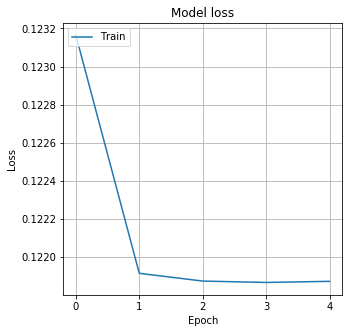

In [262]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Evaluate model performance

In [313]:
# Get the predicted values
predictions = model.predict(x_test)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test, predictions)/ y_test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test, predictions)/ y_test)) ) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Percentage Error (MAPE): 22.14 %
Median Absolute Percentage Error (MDAPE): 17.9 %


In [298]:
# Insert predictions into the original dataset
np_datax = np_data.copy()
df = pd.DataFrame(np_datax)
df.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 'Prediction']
df = pd.DataFrame(df)
rangex = np.arange(df.shape[0] - predictions.shape[0], df.shape[0], 1)
df.update(pd.Series(predictions.ravel(), name='Prediction', index=rangex))

# Inverse scale the data - including predictions - to a normal range
data_unscaled = scaler.inverse_transform(df)
data_unscaled = pd.DataFrame(data_unscaled)
data_unscaled.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 'Prediction']
data_unscaled.tail()

High          Low         Open        Close        Volume  Month  \
2614  9328.280273  9239.410156  9278.549805  9324.589844  3.641830e+09    5.0   
2615  9501.209961  9333.160156  9501.209961  9340.219727  4.432310e+09    5.0   
2616  9414.620117  9144.280273  9346.120117  9412.360352  4.462450e+09    5.0   
2617  9523.639648  9345.280273  9392.990234  9368.990234  4.064220e+09    5.0   
2618  9505.549805  9324.730469  9382.349609  9489.870117  4.710060e+09    5.0   

       Prediction  
2614  9095.983635  
2615  9183.657534  
2616  9169.760706  
2617  9120.786803  
2618  9139.882718

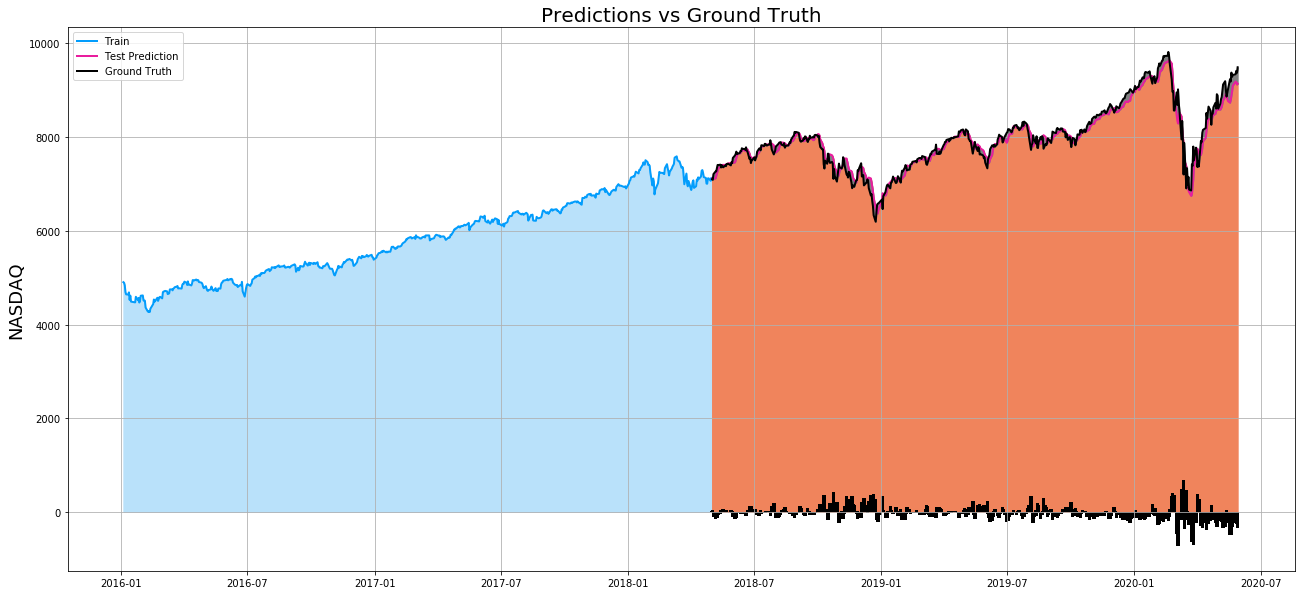

In [291]:
valid = data_unscaled.iloc[train_data_len:,]

# The date from which on the date is displayed
display_start = "2016-01-01" 
display_start_date = pd.to_datetime(display_start)
data_unscaled['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_unscaled[:train_data_len + 1]
valid = data_unscaled[train_data_len:]
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Prediction", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Prediction"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Prediction"], color="grey") 

# Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

In [293]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Prediction']
valid.insert(2, 'Difference', dif, True)
valid

High  Difference  Difference          Low         Open  \
2096  7169.459961   17.678197  -17.678197  7094.720215  7138.450195   
2097  7112.589844   38.352161  -38.352161  6991.140137  7065.029785   
2098  7228.259766 -100.142448  100.142448  7057.890137  7065.669922   
2099  7291.740234 -145.558949  145.558949  7235.759766  7241.819824   
2100  7278.810059  -94.610645   94.610645  7224.700195  7255.339844   
...           ...         ...         ...          ...          ...   
2614  9328.280273 -228.606208  228.606208  9239.410156  9278.549805   
2615  9501.209961 -156.562192  156.562192  9333.160156  9501.209961   
2616  9414.620117 -242.599645  242.599645  9144.280273  9346.120117   
2617  9523.639648 -248.203432  248.203432  9345.280273  9392.990234   
2618  9505.549805 -349.987399  349.987399  9324.730469  9382.349609   

            Close        Volume  Month   Prediction       Date  
2096  7100.899902  2.144200e+09    5.0  7118.578100 2018-05-02  
2097  7088.149902  2.345740e+09    5.0  7126.502063 2018-05-03  
2098  7209.620117  2.022230e+09    5.0  7109.477669 2018-05-04  
2099  7265.209961  1.939980e+09    5.0  7119.651012 2018-05-07  
2100  7266.899902  2.054830e+09    5.0  7172.289257 2018-05-08  
...           ...           ...    ...          ...        ...  
2614  9324.589844  3.641830e+09    5.0  9095.983635 2020-05-22  
2615  9340.219727  4.432310e+09    5.0  9183.657534 2020-05-26  
2616  9412.360352  4.462450e+09    5.0  9169.760706 2020-05-27  
2617  9368.990234  4.064220e+09    5.0  9120.786803 2020-05-28  
2618  9489.870117  4.710060e+09    5.0  9139.882718 2020-05-29  

[523 rows x 10 columns]

# Predict next day's price

In [316]:
# Get the prediction data
x_real_data_scaled = np_data[-100:]
# Here, we create 1 sample with 100 time steps
i = len(x_real_data_scaled)
x_real_data_scaled = np.array(x_real_data_scaled[i-100:i,]) # Contains 100 values 0-100 * columns

# Convert the X_test data set to a numpy array and reshape the data
x_real_reshaped = np.reshape(x_real_data_scaled, (1, x_real_data_scaled.shape[0], 
                                                  x_real_data_scaled.shape[1]))

In [317]:
# Get the predicted scaled price, undo the scaling and output the predictions
pred_price_scaled = model.predict(x_real_reshaped)

# Insert predictions into the x_real dataset
x_real = np.reshape(x_real_reshaped, (x_real_reshaped.shape[1], x_real_reshaped.shape[2]))
x_real_df = pd.DataFrame(x_real)
x_real_df.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 'Prediction']

# Transform and reverse scaling
x_real_df['Prediction'].at[x_real_df.index.max()] = pred_price_scaled
rangex = np.arange(x_real_df.shape[0] - pred_price_scaled.shape[0], x_real_df.shape[0], 1)
x_real_df.update(pd.Series(pred_price_scaled.ravel(), name='Prediction', index=rangex))
x_df = pd.DataFrame(scaler.inverse_transform(x_real_df))
x_df.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Month', 'Prediction']

# Print last price and predicted price for the next day
print('The close price for ' + stockname + ' at ' + date_today + ' was: ' + 
      str(round(x_df.at[x_df.index.max(), 'Close'])))
print('The predicted close price is: ' + 
      str(round(x_df.at[x_df.index.max(), 'Prediction'])))

The close price for NASDAQ at 2020-05-30 was: 9490.0
The predicted close price is: 9096.0
